Copyright (C) Egon Kidmose 2015-2017

This file is part of lstm-rnn-correlation.

lstm-rnn-correlation is free software: you can redistribute it and/or
modify it under the terms of the GNU Lesser General Public License as
published by the Free Software Foundation, either version 3 of the
License, or (at your option) any later version.

lstm-rnn-correlation is distributed in the hope that it will be
useful, but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public
License along with lstm-rnn-correlation. If not, see
<http://www.gnu.org/licenses/>.


In [1]:
from __future__ import division

import pandas as pd
from pandas import DataFrame
import numpy as np
import re
import datetime
import ipaddress

# matplotlib
try: # might, might not have x available
    import os
    os.environ['DISPLAY']
except KeyError:
    import matplotlib
    matplotlib.use('Agg')
try: # might, might not be notebook
    %matplotlib inline
except NameError:
    pass
import matplotlib.pyplot as plt

seed = 1468586473 # Unix time at time of writing
def rndseed():
    global seed
    seed += 1
    return seed

In [ ]:
from data_cfg import data
# load files
data_tmp = DataFrame()
for index, row in data.iterrows():
    print("Opening: {}".format(row['filename']))
    with open(row['filename']) as f:
        alerts = DataFrame(
            map(parse_line, f.readlines()),
            columns=['ts', 'rid', 'msg', 'prio', 'proto', 'srcip', 'srcport', 'dstip', 'dstport']
        )
        alerts['incident'] = row['incident']   
        data_tmp = data_tmp.append(pd.merge(data, alerts))
        print("Loaded: {}".format(row['filename']))
data = data_tmp

In [168]:
data = data_tmp

In [169]:
difficult_ips = [
    '94.63.149.152',
    '147.32.84.165',
]
for ip in difficult_ips:
    assert re.match('('+IP+')', ip).group()

difficult_ips_port = [
    '94.63.149.152:80',
    '147.32.84.165:1040',
]
for ip in difficult_ips_port:
    res = re.match(IP_PORT, ip).groups()
    assert res is not None
    assert len(res) == 2

difficult_lines = [
    '08/15-15:53:48.900440  [**] [120:3:1] (http_inspect) NO CONTENT-LENGTH OR TRANSFER-ENCODING IN HTTP RESPONSE [**] [Classification: Unknown Traffic] [Priority: 3] {TCP} 94.63.149.152:80 -> 147.32.84.165:1040\n',
]
for l in difficult_lines:
    res = parse_line(l)
    assert len(res) == 9

In [170]:
IPV4 = '(?:[0-9]{1,3}(?:\.[0-9]{1,3}){3})'
IPV6 = '(?:[0-9a-f]|:){1,4}(?::(?:[0-9a-f]{0,4})*){1,7}'
IP = '(?:{}|{})'.format(IPV4, IPV6)
IP_PORT = '('+IP+')(?::([^ ]+))?'

SNORT_REGEX = re.compile('^(.*)  \[\*\*] \[([^]]*)] (.*) \[Priority: ([0-9])] {([^}]*)} ('+IP+')(?::([^ ]+))? -> ('+IP+')(?::([^ ]+))?\n')
SNORT_TS_FMT = '%m/%d/%y-%H:%M:%S.%f'
SNORT_TS_FMT_NO_YR = '%m/%d-%H:%M:%S.%f'

def strptime(string):
    ts = None
    try:
        ts = datetime.datetime.strptime(string, SNORT_TS_FMT)
    except:
        pass
    try:
        ts = datetime.datetime.strptime(string, SNORT_TS_FMT_NO_YR)
    except:
        pass
    if ts is None:
        raise Exception('Failed to parse {}: {}'.format(type(string), string))
    return ts

def strftime(ts):
    return ts.strftime(SNORT_TS_FMT)

def parse_line(line):
    tupl = re.match(SNORT_REGEX, line).groups()
    tupl = tuple([strptime(tupl[0])]) + tupl[1:]
    return tupl


def build_line(tupl):
    tupl = tuple([strftime(tupl[0])]) + tupl[1:]
    return "{}  [**] [{}] {} [Priority: {}] {{{}}} {} -> {}\n".format(*tupl)

test_code =\
"""
for fn in data['filename']:
    for l in open(fn).readlines():
        p = parse_line(l)
        b = build_line(p)
        assert l == b or l == (b[:5]+b[8:]), "Mismatch in result"
"""

In [171]:
# data overview
# by incident
df_inc_cnt = DataFrame(data.groupby(['incident']).size().rename('inc_cnt').reset_index())
df_inc_cnt['inc_cnt_pct'] = df_inc_cnt['inc_cnt']/data.count()[0]*100

df_inc_prio_cnt = DataFrame(
    pd.merge(data, df_inc_cnt, on='incident').groupby(['incident', 'prio', 'inc_cnt']
).size().rename('inc_prio_cnt').reset_index())
df_inc_prio_cnt['inc_prio_cnt_pct'] = df_inc_prio_cnt['inc_prio_cnt']/df_inc_prio_cnt['inc_cnt']*100

df_overview = pd.merge(df_inc_cnt, df_inc_prio_cnt).groupby(['incident', 'prio']).first().reset_index()

tot_prio = data.groupby(['prio']).size().rename('inc_prio_cnt')
df_tot = DataFrame(tot_prio)
df_tot['inc_prio_cnt_pct'] = df_tot['inc_prio_cnt']/data.count()[0]*100
df_tot['inc_cnt'] = data.count()[0]
df_tot['inc_cnt_pct'] = 100
df_tot['incident'] = 'total'

df_overview = pd.concat([df_overview.reset_index(), df_tot.reset_index()])\
    .groupby(['incident', 'inc_cnt', 'inc_cnt_pct', 'prio', 'inc_prio_cnt', 'inc_prio_cnt_pct', ])\
    .first().drop('index', 1)

df_overview

Empty DataFrame
Columns: []
Index: [(1, 100, 0.00218099844364, 1, 1, 1.0), (1, 100, 0.00218099844364, 2, 79, 79.0), (1, 100, 0.00218099844364, 3, 20, 20.0), (2, 184, 0.0040130371363, 1, 3, 1.63043478261), (2, 184, 0.0040130371363, 2, 35, 19.0217391304), (2, 184, 0.0040130371363, 3, 146, 79.347826087), (3, 317, 0.00691376506634, 1, 313, 98.738170347), (3, 317, 0.00691376506634, 3, 4, 1.261829653), (4, 328, 0.00715367489514, 2, 305, 92.987804878), (4, 328, 0.00715367489514, 3, 23, 7.01219512195), (5, 390, 0.00850589393019, 2, 385, 98.7179487179), (5, 390, 0.00850589393019, 3, 5, 1.28205128205), (6, 395, 0.00861494385238, 1, 15, 3.79746835443), (6, 395, 0.00861494385238, 2, 306, 77.4683544304), (6, 395, 0.00861494385238, 3, 74, 18.7341772152), (7, 444, 0.00968363308976, 1, 35, 7.88288288288), (7, 444, 0.00968363308976, 2, 404, 90.990990991), (7, 444, 0.00968363308976, 3, 5, 1.12612612613), (benign, 4582898, 99.9529340536, 1, 67, 0.00146195704116), (benign, 4582898, 99.9529340536, 2, 3169238, 69.1535792418), (benign, 4582898, 99.9529340536, 3, 1413593, 30.8449588012), (total, 4585056, 100.0, 1, 434, 0.0094655332454), (total, 4585056, 100.0, 2, 3170752, 69.1540517717), (total, 4585056, 100.0, 3, 1413870, 30.8364826951)]

In [172]:
# print in latex friendly
for l in np.concatenate([
    np.array([df_overview.reset_index().columns]),
    df_overview.reset_index().as_matrix(),
]):
    print(('\t&'.join(['{}']*len(l)) + '\\\\\\hline').format(*l))


incident	&inc_cnt	&inc_cnt_pct	&prio	&inc_prio_cnt	&inc_prio_cnt_pct\\\hline
1	&100	&0.00218099844364	&1	&1	&1.0\\\hline
1	&100	&0.00218099844364	&2	&79	&79.0\\\hline
1	&100	&0.00218099844364	&3	&20	&20.0\\\hline
2	&184	&0.0040130371363	&1	&3	&1.63043478261\\\hline
2	&184	&0.0040130371363	&2	&35	&19.0217391304\\\hline
2	&184	&0.0040130371363	&3	&146	&79.347826087\\\hline
3	&317	&0.00691376506634	&1	&313	&98.738170347\\\hline
3	&317	&0.00691376506634	&3	&4	&1.261829653\\\hline
4	&328	&0.00715367489514	&2	&305	&92.987804878\\\hline
4	&328	&0.00715367489514	&3	&23	&7.01219512195\\\hline
5	&390	&0.00850589393019	&2	&385	&98.7179487179\\\hline
5	&390	&0.00850589393019	&3	&5	&1.28205128205\\\hline
6	&395	&0.00861494385238	&1	&15	&3.79746835443\\\hline
6	&395	&0.00861494385238	&2	&306	&77.4683544304\\\hline
6	&395	&0.00861494385238	&3	&74	&18.7341772152\\\hline
7	&444	&0.00968363308976	&1	&35	&7.88288288288\\\hline
7	&444	&0.00968363308976	&2	&404	&90.990990991\\\hline
7	&444	&0.0096836330897

In [178]:
# data time overview
df_ts = data[['incident', 'ts']].groupby('incident').agg(['min', 'max'])['ts']
df_ts.columns = ['start', 'stop', ]
df_ts['dur'] = df_ts['stop']-df_ts['start']
df_ts

,start,stop,dur
incident,,,
1,2016-05-12 05:22:21.286295771,2016-05-12 05:41:37.509218771,0 days 00:19:16.222923
2,2016-05-18 15:45:05.045046980,2016-06-02 01:01:17.111661980,14 days 09:16:12.066615
3,2016-05-24 01:02:18.272334135,2016-05-27 19:49:13.330963135,3 days 18:46:55.058629
4,2016-06-03 17:57:15.441277549,2016-06-03 20:20:44.096708549,0 days 02:23:28.655431
5,2016-05-06 12:03:16.830083735,2016-05-06 13:30:11.131837735,0 days 01:26:54.301754
6,2016-05-15 03:42:15.665750005,2016-05-15 15:45:07.124551005,0 days 12:02:51.458801
7,2016-05-28 16:53:05.469911388,2016-05-29 11:06:54.781916388,0 days 18:13:49.312005
benign,2016-05-04 09:38:44.365433000,2016-06-09 13:29:51.193338000,36 days 03:51:06.827905


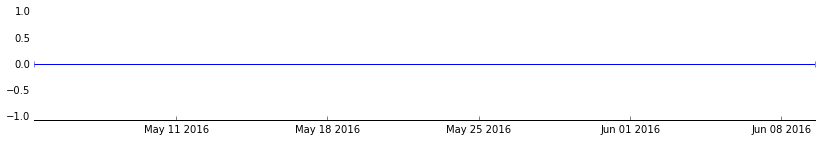

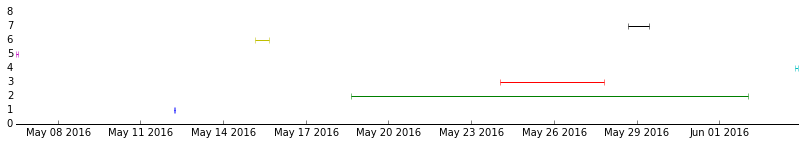

In [179]:
fig = None
ax = None
def time_span_plot(dataframe):
    "Dataframe must have 'start' and 'duration' keys"
    global fig, ax
    fig, ax = plt.subplots()
    for index, row in dataframe.iterrows():
        x = row['start'] + row['dur']/2
        y = int(index) if index is not 'benign' else 0
        xerr = row['dur']/2
        ax.errorbar(x, y, xerr=xerr)
    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.set_ylim(np.array(ax.get_ylim()) + [-1, 1])
    
    fig.set_size_inches(14, 2)

time_span_plot(df_ts[(df_ts.index == 'benign')])
time_span_plot(df_ts[(df_ts.index != 'benign')])

In [186]:
# calculate random shift to end up within boundaries of benign
new_start_min = df_ts.loc['benign']['start']
new_start_max = df_ts.loc['benign']['stop']-df_ts['dur']
window = new_start_max - new_start_min
assert (np.array(
        window+df_ts['dur']-df_ts.loc['benign']['dur'],
        dtype='object') == 0).all(), "window is wrong"

np.random.seed(rndseed())
df_ts['shift'] = new_start_min - df_ts['start'] \
    + map(lambda delta : np.random.rand()*delta, window)
df_ts

,start,stop,dur,shift
incident,,,,
1,2016-05-10 16:11:48.412702887,2016-05-10 16:31:04.635625887,0 days 00:19:16.222923,6 days 00:20:02.053905
2,2016-05-22 21:58:44.471485738,2016-06-06 07:14:56.538100738,14 days 09:16:12.066615,-9 days +12:54:57.182258
3,2016-05-05 04:32:51.029337257,2016-05-08 23:19:46.087966257,3 days 18:46:55.058629,20 days 06:46:17.396381
4,2016-06-01 21:45:11.006069090,2016-06-02 00:08:39.661500090,0 days 02:23:28.655431,-23 days +23:01:35.145677
5,2016-06-01 10:46:57.542077008,2016-06-01 12:13:51.843831008,0 days 01:26:54.301754,-23 days +03:32:37.350716
6,2016-05-27 20:18:24.723406838,2016-05-28 08:21:16.182207838,0 days 12:02:51.458801,6 days 16:13:15.289643
7,2016-06-07 00:54:00.161598049,2016-06-07 19:07:49.473603049,0 days 18:13:49.312005,-13 days +15:34:50.933630
benign,2016-05-04 09:38:44.365433000,2016-06-09 13:29:51.193338000,36 days 03:51:06.827905,0 days 00:00:00


In [187]:
# apply shift
shifted_data = pd.merge(data, df_ts.reset_index(), on='incident')
shifted_data['ts'] = shifted_data['ts'] + shifted_data['shift']
assert shifted_data['ts'].max() == data.groupby(['incident']).max().loc['benign']['ts']
assert shifted_data['ts'].min() == data.groupby(['incident']).min().loc['benign']['ts']
data = shifted_data
data = data[data_tmp.columns] # only original rows

df_ts = data[['incident', 'ts']].groupby('incident').agg(['min', 'max'])['ts']
df_ts.columns = ['start', 'stop', ]
df_ts['dur'] = df_ts['stop']-df_ts['start']
df_ts

,start,stop,dur
incident,,,
1,2016-05-16 16:31:50.466608319,2016-05-16 16:51:06.689531319,0 days 00:19:16.222923
2,2016-05-14 10:53:41.653743935,2016-05-28 20:09:53.720358935,14 days 09:16:12.066615
3,2016-05-25 11:19:08.425718726,2016-05-29 06:06:03.484347726,3 days 18:46:55.058629
4,2016-05-10 20:46:46.151746678,2016-05-10 23:10:14.807177678,0 days 02:23:28.655431
5,2016-05-09 14:19:34.892793726,2016-05-09 15:46:29.194547726,0 days 01:26:54.301754
6,2016-06-03 12:31:40.013050055,2016-06-04 00:34:31.471851055,0 days 12:02:51.458801
7,2016-05-25 16:28:51.095228517,2016-05-26 10:42:40.407233517,0 days 18:13:49.312005
benign,2016-05-04 09:38:44.365433000,2016-06-09 13:29:51.193338000,36 days 03:51:06.827905


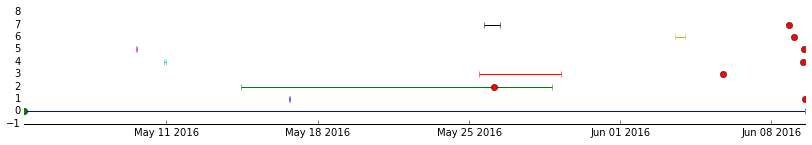

In [188]:
time_span_plot(df_ts)
ax.plot(new_start_min, 0, 'og')
ax.plot(new_start_max[:-1], range(1, len(new_start_max)), 'or')

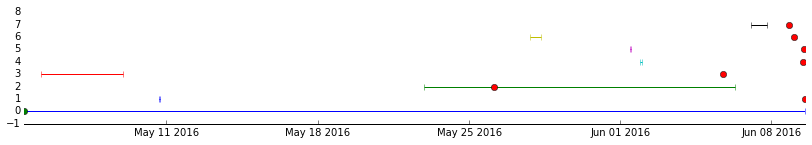

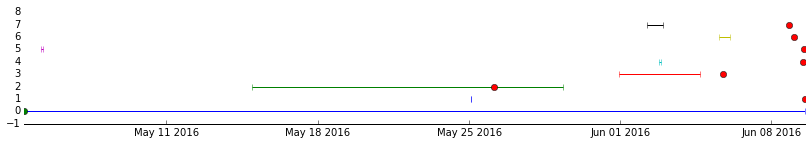

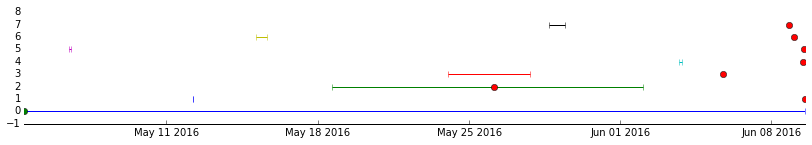

In [ ]:
# rewrite victim IPs to match benign
malicious_ips = data[data['victim_ip'] != 'benign']\
    [['incident', 'victim_ip']].drop_duplicates()

data_benign = data[data['incident'] == 'benign']
benign_ips = pd.Series(pd.concat([data_benign['srcip'],data_benign['dstip']]).unique(), name='benign_ips')
def is_private_ip(string):
    try:
        return ipaddress.IPv4Address(string).is_private
    except ipaddress.AddressValueError:
        print("ignoring IPv6 addres: {}".format(string))
        return False
    
benign_ips = benign_ips[np.array(map(is_private_ip, benign_ips))] # only private
benign_ips = benign_ips.sample(malicious_ips.shape[0], random_state=rndseed())
df_replace = DataFrame(
    zip(malicious_ips['incident'], malicious_ips['victim_ip'], benign_ips),
    columns=['incident', 'from_ip', 'to_ip']
)
df_replace

In [ ]:
# perform IP replacement
src_update = pd.merge(data.reset_index(), df_replace, left_on=['incident', 'srcip'], right_on=['incident', 'from_ip'])
src_update['srcip'] = src_update['to_ip']
src_update = src_update.drop(['from_ip', 'to_ip'], axis=1)
src_update = src_update.set_index('index')
data.update(src_update)

dst_update = pd.merge(data.reset_index(), df_replace, left_on=['incident', 'dstip'], right_on=['incident', 'from_ip'])
dst_update['dstip'] = dst_update['to_ip']
dst_update = dst_update.drop(['from_ip', 'to_ip'], axis=1)
dst_update = dst_update.set_index('index')
data.update(dst_update)

assert (np.array(src_update.groupby('incident').size()) > 0).all(), "No src updated, highly suspicous"
assert (np.array(dst_update.groupby('incident').size()) > 0).all(), "No dst updated, highly suspicous"
assert pd.merge(data, df_replace, left_on=['incident', 'srcip'], right_on=['incident', 'from_ip']).shape[0] == 0
assert pd.merge(data, df_replace, left_on=['incident', 'dstip'], right_on=['incident', 'from_ip']).shape[0] == 0

In [ ]:
start = 0 # data.shape[0]//2
stop = data.shape[0] // 2

# data overview
# by incident
df_inc_cnt = DataFrame(data[start:stop].groupby(['incident']).size().rename('inc_cnt').reset_index())
df_inc_cnt['inc_cnt_pct'] = df_inc_cnt['inc_cnt']/data[start:stop].count()[0]*100

df_inc_prio_cnt = DataFrame(
    pd.merge(data[start:stop], df_inc_cnt, on='incident').groupby(['incident', 'prio', 'inc_cnt']
).size().rename('inc_prio_cnt').reset_index())
df_inc_prio_cnt['inc_prio_cnt_pct'] = df_inc_prio_cnt['inc_prio_cnt']/df_inc_prio_cnt['inc_cnt']*100

df_overview = pd.merge(df_inc_cnt, df_inc_prio_cnt).groupby(['incident', 'prio']).first().reset_index()

tot_prio = data[start:stop].groupby(['prio']).size().rename('inc_prio_cnt')
df_tot = DataFrame(tot_prio)
df_tot['inc_prio_cnt_pct'] = df_tot['inc_prio_cnt']/data[start:stop].count()[0]*100
df_tot['inc_cnt'] = data[start:stop].count()[0]
df_tot['inc_cnt_pct'] = 100
df_tot['incident'] = 'total'

df_overview = pd.concat([df_overview.reset_index(), df_tot.reset_index()])\
    .groupby(['incident', 'inc_cnt', 'inc_cnt_pct', 'prio', 'inc_prio_cnt', 'inc_prio_cnt_pct', ])\
    .first().drop('index', 1)

df_overview